In [18]:
#importing some useful packages
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

In [246]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def canny(img, low_threshold, high_threshold):
    blur = cv2.GaussianBlur(img, (5,5),0)
    canny_img = cv2.Canny(blur, low_threshold, high_threshold)
    return canny_img

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def make_coordinates(image, line_parameters):
    slope = line_parameters[0]
    intercept = line_parameters[1]
    y1 = image.shape[0]
    y2 = 350
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    # First, define the variable for 2 lines
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        
        #take gradient and y-intercept parameter of lines
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        
        #separate between left and right line
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
        
        #more accurate calculation    
        #x_intercept = -intercept/slope
        #if (x_intercept > 0) and (x_intercept < (image.shape[1]/2)):
        #    left_fit.append((slope, intercept))
        #elif (x_intercept > (image.shape[1]/2)) and (x_intercept < (image.shape[1])):
        #    right_fit.append((slope, intercept))
    
    #average line parameter
    left_fit_average = np.average (left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    
    #make extrapolated line 
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    
    return np.array ([left_line, right_line])

def draw_lines(img, lines, color, thickness):
    line_img = np.zeros_like (img)
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img

def weighted_img(img, initial_img, a=0.8, b=1., y=0.):
    weighted_image = cv2.addWeighted(initial_img, a, img, b, y)
    return weighted_image

In [251]:
def process_image (image):

    #grayscale process
    grayscale_image = grayscale(image)

    #canny process
    low_threshold = 50
    high_threshold = 100
    canny_image = canny(grayscale_image, low_threshold, high_threshold)

    #get region of interest
    p1 = (150, image.shape[0])
    p2 = (450, 320)
    p3 = (550, 320)
    p4 = (850, image.shape[0])
    vertices = np.array([[p1, p2, p3, p4]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)

    #get lines through hough transformation
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 10
    lines = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    #get right-side line and left-side line
    average_lines = average_slope_intercept(image, lines)

    #draw line in mask
    line_img = draw_lines(image, average_lines,[255, 0, 0],10)

    #insert line into original image
    result = weighted_img(line_img, image)
    return result

('This image is:', <type 'numpy.ndarray'>, 'with dimensions:', (540, 960, 3))


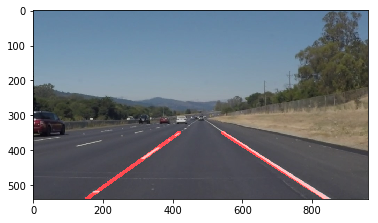

In [252]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
result = process_image(image)
#printing out some stats and plotting
print('This image is:', type(result), 'with dimensions:', result.shape)
plt.imshow(result)

('This image is:', <type 'numpy.ndarray'>, 'with dimensions:', (540, 960, 3))


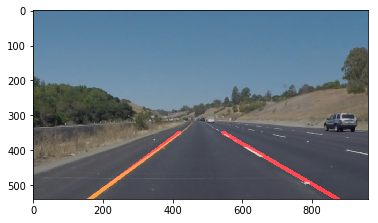

In [253]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
result = process_image(image)
#printing out some stats and plotting
print('This image is:', type(result), 'with dimensions:', result.shape)
plt.imshow(result)

In [86]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [122]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4












  0%|          | 0/222 [00:00<?, ?it/s]









  1%|▏         | 3/222 [00:00<00:07, 29.05it/s]









  3%|▎         | 7/222 [00:00<00:07, 30.45it/s]









  5%|▍         | 11/222 [00:00<00:06, 31.11it/s]









  7%|▋         | 15/222 [00:00<00:06, 31.52it/s]









  9%|▊         | 19/222 [00:00<00:06, 31.99it/s]









 10%|█         | 23/222 [00:00<00:06, 32.54it/s]









 12%|█▏        | 27/222 [00:00<00:05, 32.51it/s]









 14%|█▍        | 31/222 [00:00<00:05, 32.71it/s]









 16%|█▌        | 35/222 [00:01<00:05, 32.93it/s]









 18%|█▊        | 39/222 [00:01<00:05, 32.89it/s]









 19%|█▉        | 43/222 [00:01<00:07, 23.82it/s]









 21%|██        | 46/222 [00:01<00:09, 19.00it/s]









 22%|██▏       | 49/222 [00:01<00:09, 17.79it/s]









 23%|██▎       | 52/222 [00:02<00:10, 15.84it/s]









 24%|██▍       | 54/222 [00:02<00:11, 15.23it/s]









 25%|██▌       | 56/222 [00:02<00:11, 14.92it/s]









 26%|██▌       

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.59 s, sys: 306 ms, total: 3.89 s
Wall time: 16.4 s


In [123]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [254]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:47<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.8 s, sys: 725 ms, total: 11.5 s
Wall time: 49.7 s


In [255]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))